In [4]:
# Import
import pandas as pd
from finta import TA as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

In [12]:
ticker1 = "BTC"
ticker2 = "USDT"
pair= "{}{}".format(ticker1,ticker2)
start="2019.1.1"
end = "2022.4.1"
filepath = "Resources/{}_{}_to_{}.csv".format(pair,start,end)

df = pd.read_csv(Path(filepath), index_col= "Date", parse_dates= True, infer_datetime_format = True)
display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-01 00:00:00,3701.23,3713.00,3689.88,3700.31,686.367420
2019-01-01 01:00:00,3700.20,3702.73,3684.22,3689.69,613.539115
2019-01-01 02:00:00,3689.67,3695.95,3675.04,3690.00,895.302181
2019-01-01 03:00:00,3690.00,3699.77,3685.78,3693.13,796.714818
2019-01-01 04:00:00,3692.32,3720.00,3685.94,3692.71,1317.452909


,Open,High,Low,Close,Volume
Date,,,,,
2022-03-31 20:00:00,45581.98,45790.00,45519.03,45745.46,1550.11357
2022-03-31 21:00:00,45745.45,45849.99,45647.01,45757.19,887.89890
2022-03-31 22:00:00,45757.19,45820.34,45660.68,45787.85,1058.12591
2022-03-31 23:00:00,45787.85,45787.86,45200.00,45510.34,2889.28168
2022-04-01 00:00:00,45510.35,45644.86,45351.73,45541.50,1838.20071


In [13]:
def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

In [14]:
### Oscillators ###
## RSI
df = appendData(df,ta.RSI(df))
## Sto-%K
df = appendData(df,ta.STOCH(df))
## CCI
df = appendData(df,ta.CCI(df))
## ADX
df = appendData(df,ta.ADX(df))
## DMI (Added to aid in interpreting ADX)
df = appendData(df,ta.DMI(df, 14))
## Awesome
df = appendData(df,ta.AO(df))
## Momentum
df = appendData(df,ta.MOM(df,10))
## MACD (We rename the undescriptive "SIGNAL" here)
df = appendData(df,ta.MACD(df)).rename(columns={"SIGNAL": "MACD SIGNAL"})
## Sto-RSI
df = appendData(df,ta.STOCHRSI(df))
## Williams %R
df = appendData(df,ta.WILLIAMS(df))
## Bull-Bear Power
df = appendData(df,ta.EBBP(df))
## Ultimate (FinTA does not name this column, so we must)
df = appendData(df,ta.UO(df),["UO"])
### Moving Averages ###
sma_ema_averages = [5, 10, 20, 30, 50, 100, 200]
## SMA, EMA
for i in sma_ema_averages:
  df = appendData(df,ta.SMA(df, i))
  df = appendData(df,ta.EMA(df, i))
## VWMA
df = appendData(df, ta.VAMA(df, 20))
## Hull
df = appendData(df,ta.HMA(df, 9))
# Ichimoku -- Base (Kijun) and Conversion (Tenkan) Only
df = appendData(df,ta.ICHIMOKU(df).drop(['senkou_span_a','SENKOU','CHIKOU'], axis=1))

In [15]:
# Use the pct_change function to generate the returns from "close"
#df["actual_return"] = df["Close"].pct_change()
i = 3
i_end = 5
model = SVC()
percent_threshold = .03
investment_amount = 10000
training_length = 12
while i <= i_end:
    column_name = str(i) + "_period_return"
    df[column_name] = df["Close"].pct_change(periods=i)
    # Initialize the new `Signal` column
    signal_column_name = str(i) + "_signal"
    df[signal_column_name] = 0.0
    # Generate signal to buy stock long
    df.loc[(df[column_name] >= (percent_threshold)), signal_column_name] = 1
    # Drop all NaN values from the DataFrame
    df = df.dropna()
    y = df[signal_column_name]
    # set up X for ml 
    X = df[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "MACD", "MACD SIGNAL", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()
    y_count = y.value_counts()
    training_begin = X.index.min()
    # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
    training_end = X.index.min() + DateOffset(months=training_length)
    # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
    # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
    # Hint: Use `loc[training_end:]` for X_test and y_test
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]

    # Use StandardScaler to scale the X_train and X_test data.
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
 
    # Fit the model to the data using X_train_scaled and y_train
    model = model.fit(X_train_scaled, y_train)

    # Use the trained model to predict the trading signals for the training data.
    training_signal_predictions = model.predict(X_train_scaled)

    # Evaluate the model using a classification report
    training_report_train = classification_report(y_train, training_signal_predictions)
    print(column_name)
    print("Training Report")
    print(training_report_train)

    # Use the trained model to predict the trading signals for the testing data.
    testing_signal_predictions = model.predict(X_test_scaled)

    # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
    training_report_test = classification_report(y_test, testing_signal_predictions)
    print("Testing Report")
    print(training_report_test)

    df = df.drop([column_name, signal_column_name], axis=1)
    i+=1

df.head()

3_period_return
Training Report
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8570
         1.0       1.00      0.16      0.28       163

    accuracy                           0.98      8733
   macro avg       0.99      0.58      0.63      8733
weighted avg       0.98      0.98      0.98      8733

Testing Report
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     19009
         1.0       0.83      0.01      0.02       466

    accuracy                           0.98     19475
   macro avg       0.90      0.51      0.50     19475
weighted avg       0.97      0.98      0.96     19475

4_period_return
Training Report
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8511
         1.0       0.95      0.27      0.43       222

    accuracy                           0.98      8733
   macro avg       0.97      0.64      0.71      

,Open,High,Low,Close,Volume,14 period RSI,14 period STOCH %K,20 period CCI,14 period ADX.,DI+,DI-,AO,MOM,MACD,MACD SIGNAL,14 period stochastic RSI.,14 Williams %R,Bull.,Bear.,UO,5 period SMA,5 period EMA,10 period SMA,10 period EMA,20 period SMA,20 period EMA,30 period SMA,30 period EMA,50 period SMA,50 period EMA,100 period SMA,100 period EMA,200 period SMA,200 period EMA,20 period VAMA,9 period HMA.,TENKAN,KIJUN
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-09 16:00:00,3957.59,3977.93,3952.44,3963.03,1328.487833,45.317914,33.475156,-50.296747,11.490441,17.692572,18.859506,-14.069441,-23.60,-2.476414,0.720524,0.524066,-66.524844,6.578305,-18.911695,46.899026,3963.468,3964.370736,3973.497,3969.656125,3974.6585,3973.187626,3978.678333,3972.862611,3973.9514,3964.744886,3924.7033,3933.047189,3851.58340,3895.767806,3972.145307,3952.508000,3973.905,3986.400
2019-01-09 17:00:00,3965.05,3972.00,3955.68,3968.00,888.102025,47.694994,41.027200,-45.553296,10.897733,16.428816,17.512398,-16.725118,-19.88,-2.522140,0.071991,0.519934,-58.972800,1.127119,-15.192881,47.707574,3961.724,3965.580490,3971.509,3969.355012,3974.8970,3972.693566,3977.558667,3972.548894,3973.9132,3964.872566,3926.4449,3933.749859,3852.92365,3896.586827,3972.190249,3955.671222,3973.905,3955.420
2019-01-09 18:00:00,3967.14,3975.00,3958.00,3971.38,815.142596,49.308890,46.163197,-32.540146,10.125939,16.231415,16.261512,-16.543912,-11.16,-2.259594,-0.394326,0.514050,-53.836803,4.054673,-12.945327,51.901396,3962.382,3967.513660,3970.393,3969.723191,3975.0745,3972.568465,3976.977000,3972.473481,3973.7616,3965.127814,3928.2842,3934.506125,3854.21520,3897.433710,3972.254100,3962.727148,3973.905,3954.905
2019-01-09 19:00:00,3970.06,3983.66,3964.79,3978.34,920.183472,52.555258,56.739097,-1.559804,10.001862,17.865397,15.099975,-12.727118,0.34,-1.472932,-0.610047,0.512302,-43.260903,11.658291,-7.211709,54.753976,3967.806,3971.122440,3970.427,3971.289884,3976.2350,3973.118135,3975.364333,3972.851967,3973.7416,3965.646047,3930.2118,3935.386809,3855.56920,3898.348557,3973.995425,3971.217111,3973.905,3954.905
2019-01-09 20:00:00,3978.98,3981.00,3961.00,3967.00,881.474455,47.246159,39.507674,-48.100835,9.596526,16.589297,15.213154,-9.821618,-15.77,-1.744430,-0.836924,0.507019,-60.492326,9.712821,-10.287179,51.666218,3969.550,3969.748293,3968.850,3970.509905,3976.7985,3972.535455,3973.970667,3972.474420,3973.5238,3965.699154,3931.9099,3936.021779,3856.81920,3899.123779,3974.787040,3974.535963,3968.650,3954.905


In [6]:
#CASE 2 - Neural network.

volume_df = df["Volume"]
volume_df.tail(100)

2022-04-03 17:00:00+00:00        765952
2022-04-03 18:00:00+00:00             0
2022-04-03 19:00:00+00:00     398100480
2022-04-03 20:00:00+00:00             0
2022-04-03 21:00:00+00:00     340869120
2022-04-03 22:00:00+00:00    2549780480
2022-04-03 23:00:00+00:00     758032384
2022-04-04 00:00:00+00:00    1105248256
2022-04-04 01:00:00+00:00             0
2022-04-04 02:00:00+00:00     325373952
2022-04-04 03:00:00+00:00      88788992
2022-04-04 04:00:00+00:00     315846656
2022-04-04 05:00:00+00:00     145416192
2022-04-04 06:00:00+00:00             0
2022-04-04 07:00:00+00:00     164020224
2022-04-04 08:00:00+00:00     689442816
2022-04-04 09:00:00+00:00     323958784
2022-04-04 10:00:00+00:00     735748096
2022-04-04 11:00:00+00:00     468754432
2022-04-04 12:00:00+00:00     179089408
2022-04-04 13:00:00+00:00     363237376
2022-04-04 14:00:00+00:00     945186816
2022-04-04 15:00:00+00:00     784728064
2022-04-04 16:00:00+00:00             0
2022-04-04 17:00:00+00:00     985747456


In [16]:
# Model K-nearest neighbors.
from sklearn.neighbors import KNeighborsClassifier


i = 3
i_end = 5
model = KNeighborsClassifier(n_neighbors=3)
percent_threshold = .03
investment_amount = 10000
training_length = 12
while i <= i_end:
    column_name = str(i) + "_period_return"
    df[column_name] = df["Close"].pct_change(periods=i)
    # Initialize the new `Signal` column
    signal_column_name = str(i) + "_signal"
    df[signal_column_name] = 0.0
    # Generate signal to buy stock long
    df.loc[(df[column_name] >= (percent_threshold)), signal_column_name] = 1
    # Drop all NaN values from the DataFrame
    df = df.dropna()
    y = df[signal_column_name]
    # set up X for ml 
    X = df[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "MACD", "MACD SIGNAL", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()
    y_count = y.value_counts()
    training_begin = X.index.min()
    # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
    training_end = X.index.min() + DateOffset(months=training_length)
    # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
    # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
    # Hint: Use `loc[training_end:]` for X_test and y_test
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]

    # Use StandardScaler to scale the X_train and X_test data.
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
 
    # Fit the model to the data using X_train_scaled and y_train
    model = model.fit(X_train_scaled, y_train)

    # Use the trained model to predict the trading signals for the training data.
    training_signal_predictions = model.predict(X_train_scaled)

    # Evaluate the model using a classification report
    training_report_train = classification_report(y_train, training_signal_predictions)
    print(column_name)
    print("Training Report")
    print(training_report_train)

    # Use the trained model to predict the trading signals for the testing data.
    testing_signal_predictions = model.predict(X_test_scaled)

    # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
    training_report_test = classification_report(y_test, testing_signal_predictions)
    print("Testing Report")
    print(training_report_test)

    #df = df.drop([column_name, signal_column_name], axis=1)
    i+=1

display(df.head())
#display(list(df.columns))
#display(y_count)

3_period_return
Training Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      8570
         1.0       0.95      0.35      0.51       163

    accuracy                           0.99      8733
   macro avg       0.97      0.67      0.75      8733
weighted avg       0.99      0.99      0.98      8733

Testing Report
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18997
         1.0       0.24      0.10      0.14       466

    accuracy                           0.97     19463
   macro avg       0.61      0.55      0.56     19463
weighted avg       0.96      0.97      0.96     19463

4_period_return
Training Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      8511
         1.0       0.88      0.57      0.69       222

    accuracy                           0.99      8733
   macro avg       0.93      0.78      0.84      

,Open,High,Low,Close,Volume,14 period RSI,14 period STOCH %K,20 period CCI,14 period ADX.,DI+,DI-,AO,MOM,MACD,MACD SIGNAL,14 period stochastic RSI.,14 Williams %R,Bull.,Bear.,UO,5 period SMA,5 period EMA,10 period SMA,10 period EMA,20 period SMA,20 period EMA,30 period SMA,30 period EMA,50 period SMA,50 period EMA,100 period SMA,100 period EMA,200 period SMA,200 period EMA,20 period VAMA,9 period HMA.,TENKAN,KIJUN,3_period_return,3_signal,4_period_return,4_signal,5_period_return,5_signal
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-10 04:00:00,3978.96,3993.82,3976.14,3993.00,1075.455887,59.301056,98.405600,110.635732,16.570517,18.250147,8.479368,7.717559,21.62,2.431236,0.287137,0.522228,-1.594400,15.968780,-1.711220,56.999008,3984.608,3983.372773,3976.891,3979.108466,3973.6420,3976.465759,3975.680000,3975.215791,3974.7346,3969.245321,3946.3861,3942.348726,3868.17670,3905.945855,3972.885474,3987.641074,3974.410,3973.905,0.002652,0.0,0.001339,0.0,0.006643,0.0
2019-01-10 05:00:00,3993.00,3996.01,3986.57,3989.79,1464.983995,57.328707,85.724122,127.153343,18.148054,17.796951,7.873699,10.012059,11.45,3.175694,0.864848,0.532829,-14.275878,16.453240,7.013240,57.110873,3985.034,3985.511849,3978.036,3981.050563,3974.2315,3977.734734,3976.835333,3976.156062,3975.6182,3970.051107,3948.6275,3943.299370,3869.58460,3906.881772,3973.816791,3990.094852,3975.505,3973.905,0.002208,0.0,0.001846,0.0,0.000534,0.0
2019-01-10 06:00:00,3988.57,3990.47,3731.01,3781.31,11092.600113,17.234989,18.981132,-554.371270,20.881438,16.525740,59.307232,-11.238706,-185.69,-12.908114,-1.889744,0.512023,-81.018868,39.234205,-220.225795,33.993516,3944.808,3917.444566,3959.467,3944.734097,3964.1585,3959.027617,3971.021333,3963.585344,3972.3468,3962.648507,3948.7224,3940.054142,3869.93515,3905.481764,3924.459882,3929.657778,3863.510,3868.910,-0.049669,0.0,-0.050161,0.0,-0.050504,0.0
2019-01-10 07:00:00,3779.63,3784.73,3747.61,3777.02,4132.695870,16.971954,17.362264,-400.565504,23.419580,15.345330,55.071000,-48.050529,-189.46,-25.704509,-6.652697,0.489261,-82.637736,-141.617824,-178.737824,35.131590,3904.012,3870.636377,3940.521,3914.240625,3953.6875,3941.693558,3964.055333,3951.548867,3968.8774,3955.368023,3948.7811,3936.788741,3869.83455,3904.051250,3909.560763,3843.383370,3863.510,3868.910,-0.054090,0.0,-0.050747,0.0,-0.051238,0.0
2019-01-10 08:00:00,3777.54,3783.32,3752.50,3759.07,2371.377103,15.879905,10.588679,-257.572831,25.776426,14.249235,51.137357,-85.369500,-208.33,-36.869155,-12.695988,0.464494,-89.411321,-119.130992,-149.950992,33.498882,3860.038,3833.447585,3919.688,3886.027784,3942.8050,3924.300838,3956.669667,3939.130871,3964.8876,3947.669113,3948.6928,3933.230030,3869.73980,3902.438691,3898.128544,3759.875074,3863.510,3868.910,-0.057828,0.0,-0.058585,0.0,-0.055258,0.0


In [8]:
# investment_amount = 10000 * .05

# # Initialize the new `Signal` column
# df['signal'] = 0.0
# # Generate signal to buy stock long
# df.loc[(df['three_period_return'] >= ((investment_amount * 0.00001))), 'signal'] = 1
# # Generate signal to sell stock short
# #df.loc[(df['three_period_return'] < (investment_amount * 0.00001)), 'signal'] = 0

In [9]:
# # Copy the new "signal" column to a new Series called `y`.
# y = df['signal']
# # set up X for ml 
# X = df[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "MACD", "MACD SIGNAL", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()

In [10]:
# value counts for -1 and 1
# y.value_counts()

In [11]:
# # Use the following code to select the start of the training period: `training_begin = X.index.min()`
# training_begin = X.index.min()
# print(training_begin)

# # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
# training_end = X.index.min() + DateOffset(months=3)
# print(training_end)

# # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
# # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
# X_train = X.loc[training_begin:training_end]
# y_train = y.loc[training_begin:training_end]

# # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
# # Hint: Use `loc[training_end:]` for X_test and y_test
# X_test = X.loc[training_end:]
# y_test = y.loc[training_end:]

# # Use StandardScaler to scale the X_train and X_test data.
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaler = scaler.fit(X_train)
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [12]:
# model = SVC()
 
# # Fit the model to the data using X_train_scaled and y_train
# model = model.fit(X_train_scaled, y_train)

# # Use the trained model to predict the trading signals for the training data.
# training_signal_predictions = model.predict(X_train_scaled)

# # Evaluate the model using a classification report
# from sklearn.metrics import classification_report
# training_report = classification_report(y_train, training_signal_predictions)
# print(training_report)

In [13]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      7253
         1.0       0.53      0.40      0.46       315

    accuracy                           0.96      7568
   macro avg       0.75      0.69      0.72      7568
weighted avg       0.96      0.96      0.96      7568



In [23]:
 # Create a new empty predictions DataFrame using code provided below.
# Use the pct_change function to generate the returns from "close"
df["actual_return"] = df["Close"].pct_change()
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['signal'] = testing_signal_predictions
predictions_df['signal'].value_counts()
predictions_df["3_period_return"] = df["3_period_return"]


intial_investment = 10000
# Add in actual returns and calculate trading returns
predictions_df['actual_return'] = df['actual_return']
predictions_df['trading_algorithm_returns_3'] = predictions_df.loc[predictions_df["signal"]==1]["3_period_return"]
#predictions_df["trading_algorithm_returns_5"] = 
predictions_df["trading_algorithm_returns_3"].fillna(0, inplace=True)

predictions_df["trading_algo_returns_3_+1"] = (1 + predictions_df["trading_algorithm_returns_3"]).cumprod() - 1
# we need to add trading algo cumulative returns in order to plot agaisnt actual returns and see how well our algo performed compared to actual returns

predictions_df.tail(100)

,signal,3_period_return,actual_return,trading_algorithm_returns_3,trading_algo_returns_3_+1
2022-04-03 17:00:00+00:00,0.0,-0.002300,0.000881,0.0,90.312032
2022-04-03 18:00:00+00:00,0.0,0.004565,0.005751,0.0,90.312032
2022-04-03 19:00:00+00:00,0.0,0.002643,-0.003968,0.0,90.312032
2022-04-03 20:00:00+00:00,0.0,0.000679,-0.001080,0.0,90.312032
2022-04-03 21:00:00+00:00,0.0,0.002243,0.007324,0.0,90.312032
2022-04-03 22:00:00+00:00,0.0,0.008347,0.002098,0.0,90.312032
2022-04-03 23:00:00+00:00,0.0,0.001090,-0.008269,0.0,90.312032
2022-04-04 00:00:00+00:00,0.0,-0.016531,-0.010408,0.0,90.312032
2022-04-04 01:00:00+00:00,0.0,-0.019611,-0.001040,0.0,90.312032
2022-04-04 02:00:00+00:00,0.0,-0.008888,0.002578,0.0,90.312032


<AxesSubplot:>

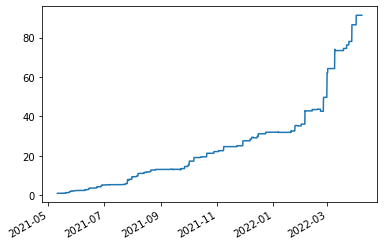

In [22]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`

display((1 + predictions_df['trading_algo_returns_3_+1']).plot())

<AxesSubplot:>

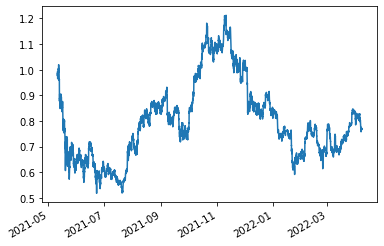

In [21]:
display((1 + predictions_df['actual_return']).cumprod().plot())